In [1]:
import itertools

%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix 
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support

In [2]:
# Fix random seed 
np.random.seed(13)

In [ ]:
# def plot_confusion_matrices(conf_matrices):
#     N, N_classes, _ = conf_matrices.shape 
    
#     classes = ['']
    
#     fig, axs = plt.subplots(1, N, figsize=(9, 3), sharey=True)
#     for i in range(N): 
#         df_cm = pd.DataFrame(conf_matrices[i])
#         plt.figure(figsize = (10,7))
#         axs[i].imshow(df_cm)

#         # We want to show all ticks...
#         axs[i].set_xticks(np.arange(N_classes))
#         axs[i].set_yticks(np.arange(N_classes))
#         # ... and label them with the respective list entries
#         axs[i].set_xticklabels(['Negative', 'Positive'])
#         axs[i].set_yticklabels(['Negative', 'Positive'])

#         # Rotate the tick labels and set their alignment.
#         plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right",
#                  rotation_mode="anchor")

#         # Loop over data dimensions and create text annotations.
#         for i in range(N_classes):
#             for j in range(N_classes):
#                 text = axs[i].text(j, i, conf_matrices[i, j],
#                                ha="center", va="center", color="w")

#     fig.tight_layout()

In [3]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [4]:
behaviour_data = pd.read_csv('data/Behavioral/cleaned/HBNFinalSummaries.csv', low_memory=False)

# Drop patients with incomplete diagnosis
initial_size = behaviour_data.shape[0]
behaviour_data = behaviour_data[behaviour_data['NoDX'].isin(['Yes', 'No'])]
new_size = behaviour_data.shape[0]
print('Removing', initial_size - new_size, 'patients as their evaluation was incomplete.')

keep_most_common_diseases = 5
healthy_diagnosis = 'No Diagnosis Given'

# these disorders should also include the no diagnosis given option
keep_most_common_diseases += 1

category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)]

# count for each disorder number of occurences
disorder_counts = {}
for val in behaviour_data[category_columns].values.reshape(-1):
    if not pd.isnull(val):
        if val in disorder_counts:
            disorder_counts[val] += 1
        else:
            disorder_counts[val] = 1
            
# sort in descending order
disorder_counts = sorted(disorder_counts.items(), key=lambda kv: -kv[1])

most_common_disorders = [x[0] for x in disorder_counts[:keep_most_common_diseases]]

# find users that have no diagnosis within these top diseases 
# filtering should cahnge anything as this should also happen at a later stage
mask = None
for col in category_columns:
    mask_col = behaviour_data[col].isin(most_common_disorders)
    if mask is None:
        mask = mask_col
    else:
        mask = mask | mask_col
    
initial_size = behaviour_data.shape[0]
behaviour_data = behaviour_data[mask]
behaviour_data = behaviour_data.reset_index(drop=True)
new_size = behaviour_data.shape[0]
print('Removing', initial_size - new_size, 'patients as their diagnoses were very uncommon.')

behaviour_data

Removing 282 patients as their evaluation was incomplete.
Removing 37 patients as their diagnoses were very uncommon.


,Anonymized.ID,EID,Sex,Age,Study.Site,NoDX,DX_01_Cat,DX_01_Sub,DX_01,DX_01_Spec,...,WISC_PSI,WISC_FSIQ,YSR_AB,YSR_AD,YSR_WD,YSR_RBB,YSR_SC,YSR_Ext,YSR_Int,YSR_Total
0,A00078864,NDARYM832PX3,1,7.048254,1,Yes,Anxiety Disorders,NaN,Generalized Anxiety Disorder,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A00078865,NDARNJ687DMC,1,6.348163,1,Yes,Depressive Disorders,NaN,Disruptive Mood Dysregulation Disorder,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A00078866,NDARRM363BXZ,0,10.052589,1,Yes,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Combined Type,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A00078867,NDARUW586LLL,1,12.319415,1,Yes,Depressive Disorders,NaN,Major Depressive Disorder,Single episode,...,NaN,NaN,9.0,12.0,8.0,7.0,9.0,16.0,29.0,85.0
4,A00078868,NDARDC298NW4,0,13.901437,1,Yes,Neurodevelopmental Disorders,Intellectual Disability,Intellectual Disability-Mild,NaN,...,NaN,NaN,8.0,10.0,5.0,2.0,11.0,10.0,26.0,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1772,A00093552,NDARJX939UCQ,1,10.203057,1,Yes,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Combined Type,NaN,...,103.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1773,A00093553,NDARJJ817UP1,0,9.126397,3,Yes,Neurodevelopmental Disorders,Specific Learning Disorder,Specific Learning Disorder with Impairment in ...,NaN,...,100.0,103.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1774,A00093557,NDARYZ986HEW,1,7.563084,3,Yes,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Combined Type,NaN,...,116.0,129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1775,A00093558,NDARPM572ZZV,0,9.832762,3,Yes,Neurodevelopmental Disorders,Specific Learning Disorder,Specific Learning Disorder with Impairment in ...,rule out,...,98.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print('Most common disorders taken into consideration: ', most_common_disorders)

Most common disorders taken into consideration:  ['Neurodevelopmental Disorders', 'Anxiety Disorders', 'Disruptive', 'No Diagnosis Given', 'Depressive Disorders', 'Elimination Disorders']


In [6]:
classes = np.zeros((len(most_common_disorders), behaviour_data.shape[0]), dtype=np.int32)

df_disorders = behaviour_data[category_columns]

for i, disorder in enumerate(most_common_disorders):
    mask = df_disorders.select_dtypes(include=[object]). \
            applymap(lambda x: disorder in x if pd.notnull(x) else False)
    
    disorder_df = df_disorders[mask.any(axis=1)]
    
    np.add.at(classes[i], disorder_df.index.values, 1)

classes = np.transpose(classes)
classes = np.column_stack((behaviour_data['EID'], classes))

labels = pd.DataFrame(data=classes, columns=['ID'] + most_common_disorders)
labels

,ID,Neurodevelopmental Disorders,Anxiety Disorders,Disruptive,No Diagnosis Given,Depressive Disorders,Elimination Disorders
0,NDARYM832PX3,1,1,0,0,0,0
1,NDARNJ687DMC,0,0,0,0,1,0
2,NDARRM363BXZ,1,0,0,0,0,0
3,NDARUW586LLL,0,0,0,0,1,0
4,NDARDC298NW4,1,0,0,0,0,0
...,...,...,...,...,...,...,...
1772,NDARJX939UCQ,1,0,1,0,0,0
1773,NDARJJ817UP1,1,0,0,0,0,0
1774,NDARYZ986HEW,1,1,1,0,0,0
1775,NDARPM572ZZV,1,0,0,0,0,0


# MRI Data

### FA Per Tract

In [7]:
fa_per_tract = pd.read_csv('data/MRI/MRI/DTI/FAPerTract.csv', low_memory=False)

# Remove "/" from the end some IDs 
fa_per_tract['ID'] = fa_per_tract['ID'].apply(lambda x: x[:-1] if "/" in x else x)

# Keep patients who have both behavioural records and MRI
patient_IDs = np.array(list(set(behaviour_data['EID'].values) & set(fa_per_tract['ID'].values)))
fa_per_tract = fa_per_tract[fa_per_tract['ID'].isin(patient_IDs)].sort_values(by='ID')
labels_fa_tr = labels[labels['ID'].isin(patient_IDs)].sort_values(by='ID')

print('Number of patients: ', len(patient_IDs))

Number of patients:  820


In [8]:
fa_per_tract

,LeftThalamicRadiation,RightThalamicRadiation,LeftCorticospinal,RightCorticospinal,LeftCingulumCingulate,RightCingulumCingulate,LeftCingulumHippocampus,RightCingulumHippocampus,CallosumForcepsMajor,CallosumForcepsMinor,...,RightILF,LeftSLF,RightSLF,LeftUncinate,RightUncinate,LeftArcuate,RightArcuate,GlobalFA,ID,ScanSite
0,0.455656,0.453115,0.620558,0.618361,0.517805,0.444551,NaN,0.297005,NaN,0.574576,...,0.420072,0.502264,0.518771,0.368745,0.423124,0.561095,0.470981,0.454698,NDARAA536PTU,SI
290,0.440407,0.420813,0.553176,0.566157,0.442870,0.462149,NaN,NaN,0.534137,0.512610,...,0.424499,0.457156,0.436721,0.394274,0.419798,0.491984,0.424049,0.439574,NDARAA948VFH,RU
774,0.360179,0.400220,0.480111,0.499736,0.408975,0.406019,0.352879,0.291959,0.503494,0.524352,...,0.406348,0.430824,0.481923,0.367575,0.405958,0.484720,0.485776,0.404561,NDARAC349YUC,CBIC
775,0.419313,0.348171,0.471267,0.485355,0.497915,0.454374,0.324658,0.350083,0.614501,0.577803,...,0.396651,0.383021,0.503697,0.365309,0.409130,0.477162,0.451965,0.418834,NDARAC350BZ0,CBIC
291,0.412105,0.428844,0.578922,0.594946,NaN,NaN,NaN,NaN,NaN,0.489935,...,0.433091,0.352073,0.380953,0.387661,0.449428,0.376423,0.435387,0.406589,NDARAC853DTE,RU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,0.445741,0.496935,0.520404,0.497049,NaN,NaN,NaN,NaN,0.606643,0.566425,...,0.374876,0.349277,0.411196,0.400458,0.405271,0.452404,0.447451,0.428610,NDARZW472CCF,RU
975,NaN,NaN,NaN,NaN,0.319956,NaN,NaN,NaN,NaN,NaN,...,0.428308,0.413686,0.438971,NaN,0.325042,0.479818,0.426632,0.365432,NDARZW873DN3,CBIC
772,0.399457,0.383633,0.526873,0.498594,0.340887,NaN,NaN,0.409829,0.570211,0.548486,...,0.330544,0.398634,0.422165,0.397124,0.444051,0.501421,0.461800,0.417440,NDARZW930MF2,RU
976,NaN,NaN,NaN,NaN,0.344458,NaN,NaN,NaN,NaN,NaN,...,0.344348,0.298890,0.347665,NaN,NaN,NaN,0.363475,0.299453,NDARZY101JNB,CBIC


In [9]:
labels_fa_tr

,ID,Neurodevelopmental Disorders,Anxiety Disorders,Disruptive,No Diagnosis Given,Depressive Disorders,Elimination Disorders
282,NDARAA536PTU,1,0,0,0,0,0
1027,NDARAA948VFH,1,0,0,0,0,1
1296,NDARAC349YUC,1,0,0,0,0,1
1358,NDARAC350BZ0,1,0,0,0,0,0
950,NDARAC853DTE,1,1,0,0,0,0
...,...,...,...,...,...,...,...
1445,NDARZW472CCF,1,0,0,0,0,0
1425,NDARZW873DN3,0,1,0,0,0,0
1003,NDARZW930MF2,0,1,0,0,0,0
1459,NDARZY101JNB,1,0,0,0,0,0


In [10]:
# Fill in missing values in MRI data
median_mri = fa_per_tract.median(axis=0, skipna=True)

fa_per_tract = fa_per_tract.fillna(value=median_mri, axis=0)

# Drop ID column
fa_per_tract = fa_per_tract.drop(columns=['ID'])

# Convert site to integer ID
scan_sites = fa_per_tract['ScanSite'].unique()
map_site_to_ID = {site: i for i, site in enumerate(scan_sites)}
fa_per_tract['ScanSite'] = fa_per_tract['ScanSite'].apply(lambda x: map_site_to_ID[x])

fa_per_tract.head()

,LeftThalamicRadiation,RightThalamicRadiation,LeftCorticospinal,RightCorticospinal,LeftCingulumCingulate,RightCingulumCingulate,LeftCingulumHippocampus,RightCingulumHippocampus,CallosumForcepsMajor,CallosumForcepsMinor,...,LeftILF,RightILF,LeftSLF,RightSLF,LeftUncinate,RightUncinate,LeftArcuate,RightArcuate,GlobalFA,ScanSite
0,0.455656,0.453115,0.620558,0.618361,0.517805,0.444551,0.359974,0.297005,0.556358,0.574576,...,0.464961,0.420072,0.502264,0.518771,0.368745,0.423124,0.561095,0.470981,0.454698,0
290,0.440407,0.420813,0.553176,0.566157,0.442870,0.462149,0.359974,0.366497,0.534137,0.512610,...,0.420261,0.424499,0.457156,0.436721,0.394274,0.419798,0.491984,0.424049,0.439574,1
774,0.360179,0.400220,0.480111,0.499736,0.408975,0.406019,0.352879,0.291959,0.503494,0.524352,...,0.381622,0.406348,0.430824,0.481923,0.367575,0.405958,0.484720,0.485776,0.404561,2
775,0.419313,0.348171,0.471267,0.485355,0.497915,0.454374,0.324658,0.350083,0.614501,0.577803,...,0.356345,0.396651,0.383021,0.503697,0.365309,0.409130,0.477162,0.451965,0.418834,2
291,0.412105,0.428844,0.578922,0.594946,0.453970,0.438292,0.359974,0.366497,0.556358,0.489935,...,0.420261,0.433091,0.352073,0.380953,0.387661,0.449428,0.376423,0.435387,0.406589,1


### Binary Classification 

We first study the prediction of a subject having a specific disorder versus being "healthy".

In [11]:
metrics = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1_score']

def compute_scores(y_true, y_pred, metrics): 
    d = {}
    
    for metric in metrics: 
        if metric == 'accuracy': 
            d[metric] = accuracy_score(y_true, y_pred)
        elif metric == 'balanced_accuracy': 
            d[metric] = balanced_accuracy_score(y_true, y_pred)
        elif metric == 'precision': 
            d[metric] = precision_score(y_true, y_pred, average='weighted')
        elif metric == 'recall': 
            d[metric] = recall_score(y_true, y_pred, average='weighted')
        elif metric == 'f1_score': 
            d[metric] = f1_score(y_true, y_pred, average='weighted')
        else: 
            raise ValueError('You provided a non-supported evaluation metric.')
            
    return d

#### Random Forest 

In [12]:
# Initialize results 
fa_tract_rf_res = {}
fa_tract_rf_conf = []

# Run for each disorder separately 
classifier = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1, class_weight='balanced')
                                          
for disorder in most_common_disorders: 
    if disorder == 'No Diagnosis Given': 
        continue

    mask = (labels_fa_tr[disorder] == 1) | (labels_fa_tr['No Diagnosis Given'] == 1)
    
    X = fa_per_tract[mask.values].values
    Y = labels_fa_tr[mask.values]
    
    # Binary labels for current disorder 
    y_true = Y[disorder].values.astype(int)

    skf = StratifiedKFold(n_splits=5, shuffle=True)
    
    # Initialize
    y_pred = np.empty(len(y_true))
        
    for train_index, test_index in skf.split(X, y_true):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_true[train_index], y_true[test_index]
        
        scaler = StandardScaler()
        Z_train = scaler.fit_transform(X_train)
    
        # Training 
        classifier.fit(Z_train, y_train)
        
        # Testing 
        Z_test = scaler.transform(X_test)
        
        y_pred[test_index] = classifier.predict(Z_test)
        
    print('================================= {0} ================================='.format(disorder))
    
    fa_tract_rf_res[disorder] = compute_scores(y_true, y_pred, metrics)
    
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, beta=1.0)
    
    print('accuracy {:.3f} balanced_accuracy {:.3f} precision {:.3f} {:.3f} recall {:.3f} {:.3f} f1_score {:.3f} {:>3f}' \
              .format(accuracy, balanced_accuracy, precision[0], precision[1], recall[0], recall[1], f1[0], f1[1]))

    conf = confusion_matrix(y_true, y_pred)
    fa_tract_rf_conf.append(conf)
    print(conf)   

# To numpy array 
fa_tract_rf_conf = np.array(fa_tract_rf_conf)


================================= Neurodevelopmental Disorders =================================
accuracy 0.780 balanced_accuracy 0.547 precision 0.253 0.858 recall 0.209 0.885 f1_score 0.229 0.871369
[[ 23  87]
 [ 68 525]]
================================= Anxiety Disorders =================================
accuracy 0.627 balanced_accuracy 0.584 precision 0.454 0.715 recall 0.445 0.722 f1_score 0.450 0.718310
[[ 49  61]
 [ 59 153]]
================================= Disruptive =================================
accuracy 0.574 balanced_accuracy 0.572 precision 0.557 0.589 recall 0.536 0.608 f1_score 0.546 0.598361
[[59 51]
 [47 73]]
================================= Depressive Disorders =================================
accuracy 0.574 balanced_accuracy 0.560 precision 0.590 0.544 recall 0.718 0.402 f1_score 0.648 0.462500
[[79 31]
 [55 37]]
================================= Elimination Disorders =================================
accuracy 0.682 balanced_accuracy 0.566 precision 0.748 0.41

#### SVM

In [13]:
# Initialize results 
fa_tract_svm_res = {}
fa_tract_svm_conf = []

# Run for each disorder separately 
classifier = SVC(gamma='scale', class_weight='balanced')
                                          
for disorder in most_common_disorders: 
    if disorder == 'No Diagnosis Given': 
        continue

    mask = (labels_fa_tr[disorder] == 1) | (labels_fa_tr['No Diagnosis Given'] == 1)
    
    X = fa_per_tract[mask.values].values
    Y = labels_fa_tr[mask.values]
    
    # Binary labels for current disorder 
    y_true = Y[disorder].values.astype(int)

    skf = KFold(n_splits=5, random_state=42, shuffle=True)
    
    # Initialize
    y_pred = np.empty(len(y_true))
        
    for train_index, test_index in skf.split(X, y_true):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_true[train_index], y_true[test_index]
        
        scaler = StandardScaler()
        Z_train = scaler.fit_transform(X_train)
    
        # Training 
        classifier.fit(Z_train, y_train)
        
        # Testing 
        Z_test = scaler.transform(X_test)
        
        y_pred[test_index] = classifier.predict(Z_test)
        
    print('================================= {0} ================================='.format(disorder))
    
    fa_tract_svm_res[disorder] = compute_scores(y_true, y_pred, metrics)
        
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, beta=1.0)
    
    print('accuracy {:.3f} balanced_accuracy {:.3f} precision {:.3f} {:.3f} recall {:.3f} {:.3f} f1_score {:.3f} {:>3f}' \
              .format(accuracy, balanced_accuracy, precision[0], precision[1], recall[0], recall[1], f1[0], f1[1]))

    conf = confusion_matrix(y_true, y_pred)
    fa_tract_svm_conf.append(conf)
    print(conf)    
    
# To numpy array 
fa_tract_svm_conf = np.array(fa_tract_svm_conf)

================================= Neurodevelopmental Disorders =================================
accuracy 0.653 balanced_accuracy 0.583 precision 0.221 0.877 recall 0.482 0.685 f1_score 0.303 0.768939
[[ 53  57]
 [187 406]]
================================= Anxiety Disorders =================================
accuracy 0.609 balanced_accuracy 0.607 precision 0.446 0.747 recall 0.600 0.613 f1_score 0.512 0.673575
[[ 66  44]
 [ 82 130]]
================================= Disruptive =================================
accuracy 0.557 balanced_accuracy 0.557 precision 0.534 0.579 recall 0.564 0.550 f1_score 0.549 0.564103
[[62 48]
 [54 66]]
================================= Depressive Disorders =================================
accuracy 0.604 balanced_accuracy 0.598 precision 0.629 0.570 recall 0.664 0.533 f1_score 0.646 0.550562
[[73 37]
 [43 49]]
================================= Elimination Disorders =================================
accuracy 0.623 balanced_accuracy 0.655 precision 0.842 0.41


### FA Tract Results

#### Random Forest

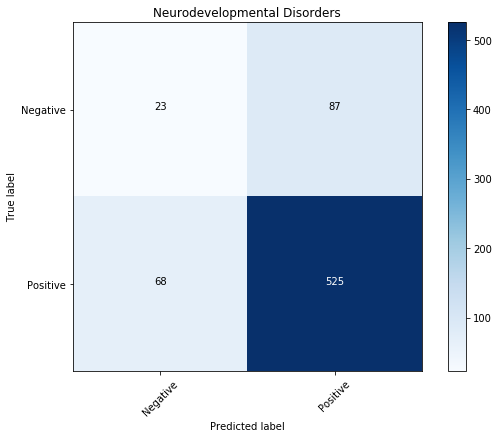

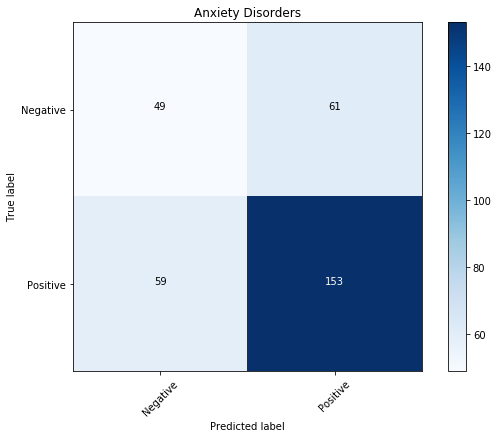

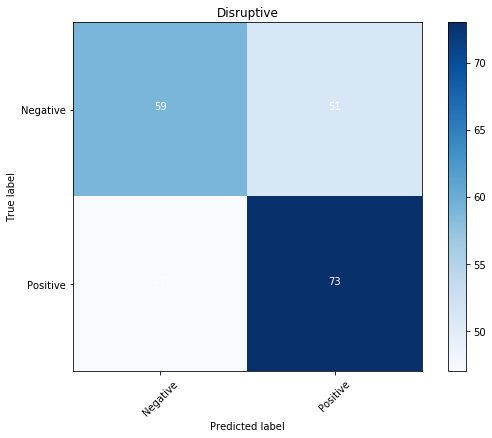

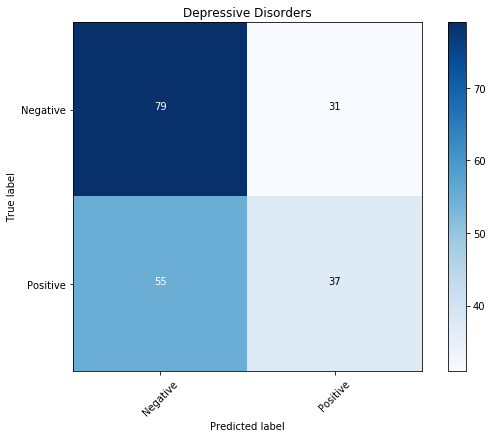

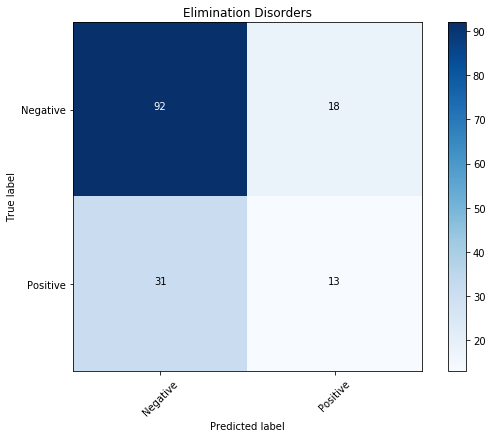

In [14]:
i = 0
for disorder in most_common_disorders: 
    if disorder == 'No Diagnosis Given': 
        continue

    plot_confusion_matrix(fa_tract_rf_conf[i], target_names=['Negative', 'Positive'], title=disorder)
    i += 1

#### SVM

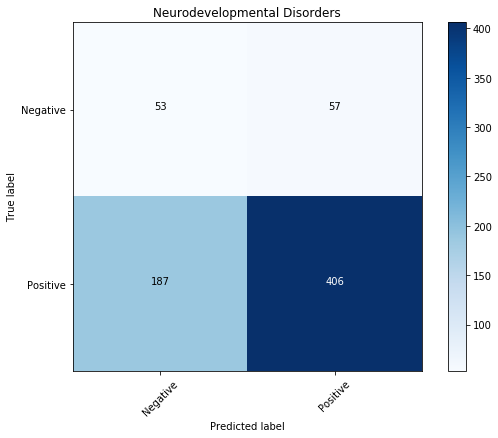

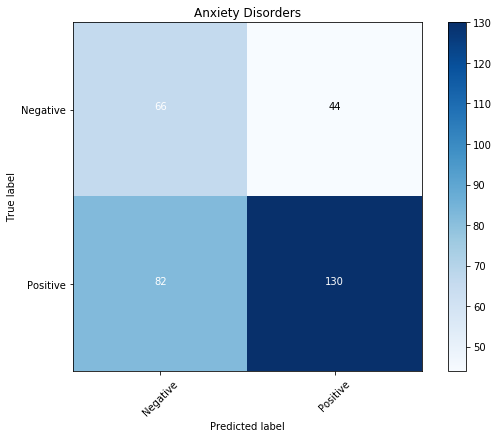

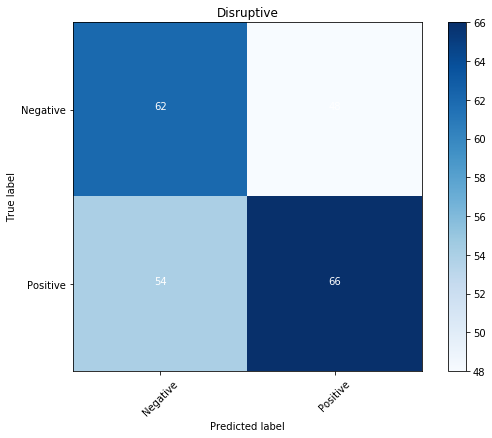

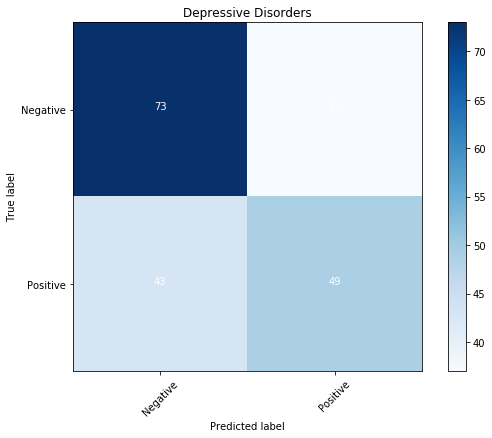

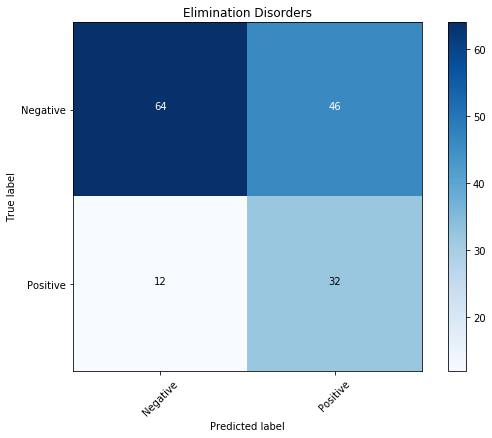

In [15]:
i = 0
for disorder in most_common_disorders: 
    if disorder == 'No Diagnosis Given': 
        continue

    plot_confusion_matrix(fa_tract_svm_conf[i], target_names=['Negative', 'Positive'], title=disorder)
    i += 1

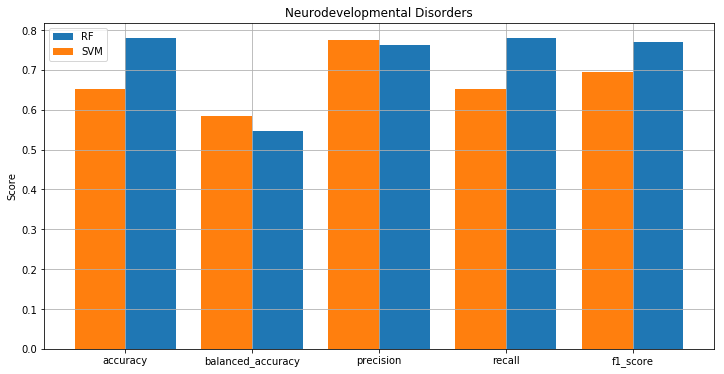

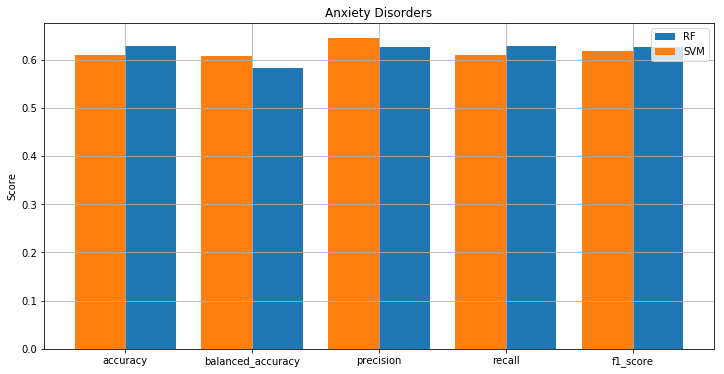

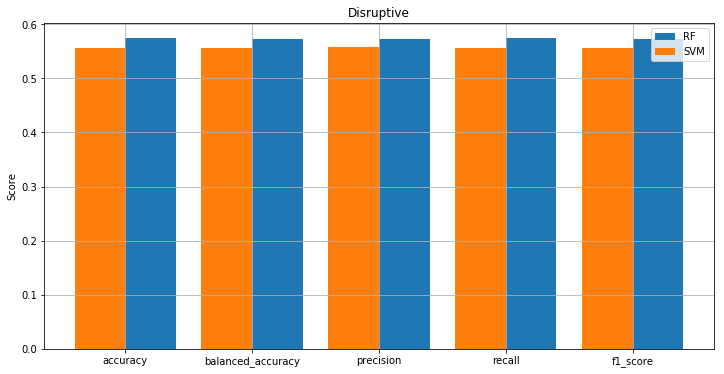

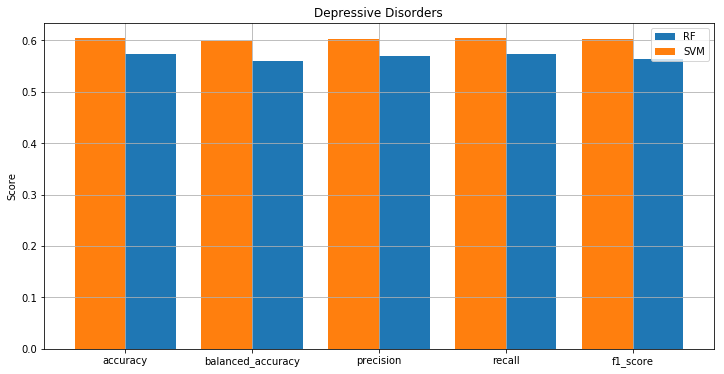

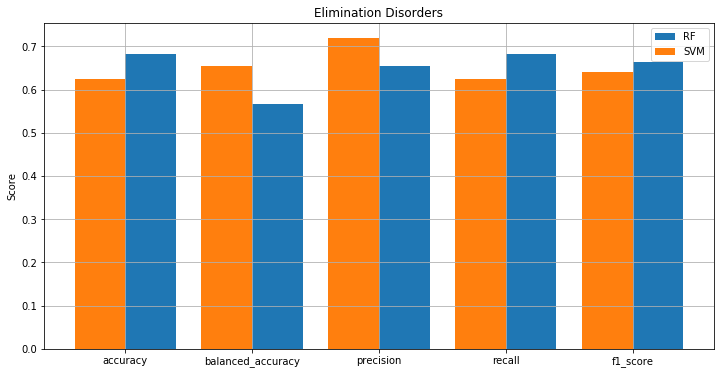

In [16]:
for disorder in most_common_disorders: 
    if disorder == 'No Diagnosis Given': 
        continue

    rf_values = [v for v in fa_tract_rf_res[disorder].values()]
    svm_values = [v for v in fa_tract_svm_res[disorder].values()]
    x = np.arange(len(metrics))  # the label locations
    width = 0.4 # the width of the bars

    fig, ax = plt.subplots(figsize=(12,6))
    rects_rf = ax.bar(x + width/2, rf_values, width, label='RF')
    rects_svm = ax.bar(x - width/2, svm_values, width, label='SVM')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Score')
    ax.set_title(disorder)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.grid(True)
    ax.legend()

## Structural MRI

We will consider merging all tables together into a single table (features). For that we will keep only one column descriping the scan site and eTIV (common to all tables). 

In [17]:
cort_thick_l = pd.read_csv('data/MRI/MRI/structuralMRI/CorticalThicknessLHROI.csv', low_memory=False)

cort_thick_l.head()

,ID,lh_G.S_frontomargin_thickness,lh_G.S_occipital_inf_thickness,lh_G.S_paracentral_thickness,lh_G.S_subcentral_thickness,lh_G.S_transv_frontopol_thickness,lh_G.S_cingul.Ant_thickness,lh_G.S_cingul.Mid.Ant_thickness,lh_G.S_cingul.Mid.Post_thickness,lh_G_cingul.Post.dorsal_thickness,...,lh_S_precentral.sup.part_thickness,lh_S_suborbital_thickness,lh_S_subparietal_thickness,lh_S_temporal_inf_thickness,lh_S_temporal_sup_thickness,lh_S_temporal_transverse_thickness,lh_MeanThickness_thickness,BrainSegVolNotVent,eTIV,ScanSite
0,NDARAA075AMK,2.683,2.715,2.422,2.856,3.240,2.978,2.887,2.779,3.188,...,2.615,2.777,2.596,2.694,2.693,2.621,2.78542,1163044,1.430219e+06,SI
1,NDARAA536PTU,2.432,2.871,2.536,2.790,2.782,2.971,2.832,2.994,2.932,...,2.562,2.623,2.339,2.732,2.758,2.321,2.72152,1203675,1.565744e+06,SI
2,NDARAD481FXF,2.544,2.585,2.410,2.837,2.990,2.857,2.674,2.786,2.991,...,2.566,2.735,2.416,2.475,2.599,2.275,2.64461,1238668,1.722067e+06,SI
3,NDARAE199TDD,2.378,2.456,2.531,2.811,2.754,2.948,2.910,2.744,3.103,...,2.577,3.035,2.518,2.668,2.701,2.655,2.60595,1179246,1.491174e+06,SI
4,NDARAJ366ZFA,2.789,2.436,2.281,2.598,2.905,3.078,2.697,2.655,3.034,...,2.449,2.922,2.434,2.625,2.622,2.258,2.59074,1007569,1.331829e+06,SI


In [18]:
cort_thick_r = pd.read_csv('data/MRI/MRI/structuralMRI/CorticalThicknessRHROI.csv', low_memory=False)

cort_thick_r = cort_thick_r.drop(columns=['eTIV', 'ScanSite'])
cort_thick_r.head()

,ID,rh_G.S_frontomargin_thickness,rh_G.S_occipital_inf_thickness,rh_G.S_paracentral_thickness,rh_G.S_subcentral_thickness,rh_G.S_transv_frontopol_thickness,rh_G.S_cingul.Ant_thickness,rh_G.S_cingul.Mid.Ant_thickness,rh_G.S_cingul.Mid.Post_thickness,rh_G_cingul.Post.dorsal_thickness,...,rh_S_postcentral_thickness,rh_S_precentral.inf.part_thickness,rh_S_precentral.sup.part_thickness,rh_S_suborbital_thickness,rh_S_subparietal_thickness,rh_S_temporal_inf_thickness,rh_S_temporal_sup_thickness,rh_S_temporal_transverse_thickness,rh_MeanThickness_thickness,BrainSegVolNotVent
0,NDARAA075AMK,2.784,2.962,2.348,2.972,3.008,2.969,2.917,2.731,3.161,...,2.586,2.645,2.640,3.333,2.562,2.786,2.837,3.089,2.82064,1163044
1,NDARAA536PTU,2.483,2.882,2.505,2.902,2.827,2.853,2.915,2.822,3.182,...,2.328,2.521,2.460,2.617,2.495,2.660,2.683,2.383,2.70309,1203675
2,NDARAD481FXF,2.384,2.547,2.421,2.821,3.104,2.712,2.777,2.677,2.818,...,2.294,2.600,2.446,2.453,2.440,2.472,2.701,2.723,2.64806,1238668
3,NDARAE199TDD,2.460,2.442,2.333,2.674,2.661,2.883,2.811,2.908,3.103,...,2.462,2.648,2.603,2.906,2.546,2.746,2.684,2.941,2.60237,1179246
4,NDARAJ366ZFA,2.727,2.702,2.277,2.690,2.724,2.867,2.709,2.700,3.151,...,2.294,2.469,2.654,2.523,2.541,2.631,2.772,3.160,2.66911,1007569


In [19]:
cort_vol_l = pd.read_csv('data/MRI/MRI/structuralMRI/CorticalVolumeLHROI.csv', low_memory=False)

cort_vol_l = cort_vol_l.drop(columns=['eTIV', 'ScanSite'])
cort_vol_l.head()

,ID,lh_G.S_frontomargin_volume,lh_G.S_occipital_inf_volume,lh_G.S_paracentral_volume,lh_G.S_subcentral_volume,lh_G.S_transv_frontopol_volume,lh_G.S_cingul.Ant_volume,lh_G.S_cingul.Mid.Ant_volume,lh_G.S_cingul.Mid.Post_volume,lh_G_cingul.Post.dorsal_volume,...,lh_S_pericallosal_volume,lh_S_postcentral_volume,lh_S_precentral.inf.part_volume,lh_S_precentral.sup.part_volume,lh_S_suborbital_volume,lh_S_subparietal_volume,lh_S_temporal_inf_volume,lh_S_temporal_sup_volume,lh_S_temporal_transverse_volume,BrainSegVolNotVent
0,NDARAA075AMK,2537,3984,3734,3921,2530,5344,2675,2654,2086,...,1395,4230,2522,2664,1252,2271,3647,11423,662,1163044
1,NDARAA536PTU,3007,3783,3014,4842,2272,5052,3166,2798,2379,...,1762,4860,4166,2116,1554,1286,3241,13213,834,1203675
2,NDARAD481FXF,2929,4492,2965,4222,2496,4802,2154,3050,1797,...,1280,4769,2653,3063,1572,1788,1979,11081,911,1238668
3,NDARAE199TDD,2818,3402,4553,4934,2103,4778,2674,3501,1926,...,1310,5216,3641,2077,2028,1808,3516,9591,605,1179246
4,NDARAJ366ZFA,2949,3392,2576,3657,2351,4187,2136,2404,1754,...,1286,4041,2797,1981,1140,1354,2040,10467,691,1007569


In [20]:
cort_vol_r = pd.read_csv('data/MRI/MRI/structuralMRI/CorticalVolumeRHROI.csv', low_memory=False)

cort_vol_r = cort_vol_r.drop(columns=['eTIV', 'ScanSite'])
cort_vol_r.head()

,ID,rh_G.S_frontomargin_volume,rh_G.S_occipital_inf_volume,rh_G.S_paracentral_volume,rh_G.S_subcentral_volume,rh_G.S_transv_frontopol_volume,rh_G.S_cingul.Ant_volume,rh_G.S_cingul.Mid.Ant_volume,rh_G.S_cingul.Mid.Post_volume,rh_G_cingul.Post.dorsal_volume,...,rh_S_pericallosal_volume,rh_S_postcentral_volume,rh_S_precentral.inf.part_volume,rh_S_precentral.sup.part_volume,rh_S_suborbital_volume,rh_S_subparietal_volume,rh_S_temporal_inf_volume,rh_S_temporal_sup_volume,rh_S_temporal_transverse_volume,BrainSegVolNotVent
0,NDARAA075AMK,2239,2847,2950,4097,4045,6140,2787,3205,2078,...,1193,4084,2969,2166,819,2253,2016,13378,433,1163044
1,NDARAA536PTU,2276,3937,2557,3738,3342,7035,3697,3464,2157,...,1794,3949,2287,3111,705,1881,2542,12503,681,1203675
2,NDARAD481FXF,2182,2864,2828,3767,3495,6432,3234,3304,1660,...,1827,3029,3231,3061,532,2114,2375,11006,525,1238668
3,NDARAE199TDD,2212,2661,2805,3744,3360,6394,3220,3077,1695,...,1183,4976,2390,2606,540,2519,1775,10427,474,1179246
4,NDARAJ366ZFA,2121,2813,2876,2637,2983,5158,2136,2626,1644,...,1221,3085,1393,1910,404,1459,2114,10696,396,1007569


In [21]:
sub_cort_vol_l = pd.read_csv('data/MRI/MRI/structuralMRI/SubCorticalVolumeLHROI.csv', low_memory=False)

sub_cort_vol_l = sub_cort_vol_l.drop(columns=['eTIV', 'ScanSite'])
sub_cort_vol_l.head()

,ID,lh_bankssts_volume,lh_caudalanteriorcingulate_volume,lh_caudalmiddlefrontal_volume,lh_cuneus_volume,lh_entorhinal_volume,lh_fusiform_volume,lh_inferiorparietal_volume,lh_inferiortemporal_volume,lh_isthmuscingulate_volume,...,lh_rostralmiddlefrontal_volume,lh_superiorfrontal_volume,lh_superiorparietal_volume,lh_superiortemporal_volume,lh_supramarginal_volume,lh_frontalpole_volume,lh_temporalpole_volume,lh_transversetemporal_volume,lh_insula_volume,BrainSegVolNotVent
0,NDARAA075AMK,2620,1557,7569,3394,1777,11615,17965,14871,3397,...,22054,28647,14504,14631,11260,1279,2065,1198,8120,1163044
1,NDARAA536PTU,3997,2064,8685,3968,1827,10736,13907,15831,3201,...,22393,29687,14302,17490,16639,1033,2728,1575,8855,1203675
2,NDARAD481FXF,2448,1572,6925,3857,2249,11908,15787,13426,2878,...,19555,28820,15161,14622,13690,1605,2549,1418,8016,1238668
3,NDARAE199TDD,2749,2118,7176,4073,1440,10891,15611,10556,2936,...,21036,24353,17669,12520,15564,1242,2035,1292,7116,1179246
4,NDARAJ366ZFA,3266,1659,5506,3003,1606,8672,13777,11025,3194,...,15484,21556,14132,14035,12019,1258,2825,1175,6893,1007569


In [22]:
sub_cort_vol_r = pd.read_csv('data/MRI/MRI/structuralMRI/SubCorticalVolumeRHROI.csv', low_memory=False)

sub_cort_vol_r = sub_cort_vol_r.drop(columns=['eTIV', 'ScanSite'])
sub_cort_vol_r.head()

,ID,rh_bankssts_volume,rh_caudalanteriorcingulate_volume,rh_caudalmiddlefrontal_volume,rh_cuneus_volume,rh_entorhinal_volume,rh_fusiform_volume,rh_inferiorparietal_volume,rh_inferiortemporal_volume,rh_isthmuscingulate_volume,...,rh_rostralmiddlefrontal_volume,rh_superiorfrontal_volume,rh_superiorparietal_volume,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume,BrainSegVolNotVent
0,NDARAA075AMK,2644,1878,7640,3385,1550,12074,21654,11967,3028,...,23310,28109,15406,14267,12552,1788,2667,1038,6893,1163044
1,NDARAA536PTU,2411,2744,7146,4073,2002,12453,19378,14207,3144,...,20887,28753,13475,16053,11576,1465,3062,1406,9631,1203675
2,NDARAD481FXF,2545,2370,8183,3910,1994,10557,18780,12283,2705,...,18474,27400,15945,14899,12247,1548,2587,1122,7734,1238668
3,NDARAE199TDD,2162,1378,5722,4855,1510,11434,16093,11760,2812,...,21894,26249,20132,12680,12751,1246,2469,1063,7032,1179246
4,NDARAJ366ZFA,2463,1528,4250,3348,1882,10093,16268,11554,2159,...,16755,20850,12257,13107,9861,1689,2280,918,6808,1007569


In [23]:
glob_thick = pd.read_csv('data/MRI/MRI/structuralMRI/GlobalCorticalThickness.csv', low_memory=False)

glob_thick = glob_thick.drop(columns=['ScanSite'])
glob_thick.head()

,ID,GlobalCorticalThickness
0,NDARAA075AMK,2.803030
1,NDARAA536PTU,2.712315
2,NDARAD481FXF,2.646340
3,NDARAE199TDD,2.604245
4,NDARAJ366ZFA,2.630035


In [24]:
# Join tables 
struct_mri = pd.merge(cort_thick_l, cort_thick_r, on='ID', how='inner')
struct_mri = pd.merge(struct_mri, cort_vol_l, on='ID', how='inner')
struct_mri = pd.merge(struct_mri, cort_vol_r, on='ID', how='inner')
struct_mri = pd.merge(struct_mri, sub_cort_vol_l, on='ID', how='inner')
struct_mri = pd.merge(struct_mri, sub_cort_vol_r, on='ID', how='inner')
struct_mri = pd.merge(struct_mri, glob_thick, on='ID', how='inner')

struct_mri.head()

,ID,lh_G.S_frontomargin_thickness,lh_G.S_occipital_inf_thickness,lh_G.S_paracentral_thickness,lh_G.S_subcentral_thickness,lh_G.S_transv_frontopol_thickness,lh_G.S_cingul.Ant_thickness,lh_G.S_cingul.Mid.Ant_thickness,lh_G.S_cingul.Mid.Post_thickness,lh_G_cingul.Post.dorsal_thickness,...,rh_superiorfrontal_volume,rh_superiorparietal_volume,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume,BrainSegVolNotVent_y,GlobalCorticalThickness
0,NDARAA075AMK,2.683,2.715,2.422,2.856,3.240,2.978,2.887,2.779,3.188,...,28109,15406,14267,12552,1788,2667,1038,6893,1163044,2.803030
1,NDARAA536PTU,2.432,2.871,2.536,2.790,2.782,2.971,2.832,2.994,2.932,...,28753,13475,16053,11576,1465,3062,1406,9631,1203675,2.712315
2,NDARAD481FXF,2.544,2.585,2.410,2.837,2.990,2.857,2.674,2.786,2.991,...,27400,15945,14899,12247,1548,2587,1122,7734,1238668,2.646340
3,NDARAE199TDD,2.378,2.456,2.531,2.811,2.754,2.948,2.910,2.744,3.103,...,26249,20132,12680,12751,1246,2469,1063,7032,1179246,2.604245
4,NDARAJ366ZFA,2.789,2.436,2.281,2.598,2.905,3.078,2.697,2.655,3.034,...,20850,12257,13107,9861,1689,2280,918,6808,1007569,2.630035


In [25]:
# Remove "/" from the end some IDs 
struct_mri['ID'] = struct_mri['ID'].apply(lambda x: x[:-1] if "/" in x else x)

# Keep patients who have both behavioural records and MRI
patient_IDs = np.array(list(set(behaviour_data['EID'].values) & set(struct_mri['ID'].values)))
struct_mri = struct_mri[struct_mri['ID'].isin(patient_IDs)].sort_values(by='ID')
labels_str = labels[labels['ID'].isin(patient_IDs)].sort_values(by='ID')

print('Number of patients: ', len(patient_IDs))

Number of patients:  1053


In [26]:
struct_mri

,ID,lh_G.S_frontomargin_thickness,lh_G.S_occipital_inf_thickness,lh_G.S_paracentral_thickness,lh_G.S_subcentral_thickness,lh_G.S_transv_frontopol_thickness,lh_G.S_cingul.Ant_thickness,lh_G.S_cingul.Mid.Ant_thickness,lh_G.S_cingul.Mid.Post_thickness,lh_G_cingul.Post.dorsal_thickness,...,rh_superiorfrontal_volume,rh_superiorparietal_volume,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume,BrainSegVolNotVent_y,GlobalCorticalThickness
0,NDARAA075AMK,2.683,2.715,2.422,2.856,3.240,2.978,2.887,2.779,3.188,...,28109,15406,14267,12552,1788,2667,1038,6893,1163044,2.803030
1,NDARAA536PTU,2.432,2.871,2.536,2.790,2.782,2.971,2.832,2.994,2.932,...,28753,13475,16053,11576,1465,3062,1406,9631,1203675,2.712315
335,NDARAA948VFH,2.750,2.679,2.703,3.432,3.246,3.391,3.161,3.089,3.480,...,25548,16960,13756,11335,1461,2682,1095,6799,1107657,2.928645
1091,NDARAC349YUC,2.392,2.941,2.570,2.612,2.556,3.279,3.056,3.232,3.388,...,27930,14229,12823,12948,945,2630,1126,8154,1154134,2.745770
1092,NDARAC350BZ0,2.793,3.023,2.544,3.395,2.981,3.254,3.182,3.161,3.562,...,26828,13366,12491,11728,1985,1924,883,7721,1218600,2.856230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,NDARZW873DN3,2.710,2.551,3.130,3.149,2.836,3.188,3.201,3.137,3.276,...,27865,18401,13675,11022,1386,2710,965,8743,1276325,2.820720
1088,NDARZW930MF2,2.632,2.500,2.210,2.810,2.603,3.109,3.043,2.965,3.284,...,24560,18542,12707,10961,1323,3052,1216,7754,1164539,2.706000
1299,NDARZY101JNB,2.864,2.867,2.924,3.173,3.009,3.208,3.229,2.997,3.521,...,28699,18519,15479,15710,1405,2802,1217,8770,1289003,2.996145
1089,NDARZY668NMV,2.849,2.659,2.638,2.952,3.304,3.135,3.225,2.897,3.032,...,22706,12795,11910,12836,1430,2626,934,6611,1008736,2.717490


In [27]:
labels_str

,ID,Neurodevelopmental Disorders,Anxiety Disorders,Disruptive,No Diagnosis Given,Depressive Disorders,Elimination Disorders
308,NDARAA075AMK,0,0,0,1,0,0
282,NDARAA536PTU,1,0,0,0,0,0
1027,NDARAA948VFH,1,0,0,0,0,1
1296,NDARAC349YUC,1,0,0,0,0,1
1358,NDARAC350BZ0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
1425,NDARZW873DN3,0,1,0,0,0,0
1003,NDARZW930MF2,0,1,0,0,0,0
1459,NDARZY101JNB,1,0,0,0,0,0
732,NDARZY668NMV,1,0,1,0,0,0


In [28]:
# Check that IDs from the features and labels tables match
if any(struct_mri['ID'].values != labels_str['ID'].values):
    print('There is a mismatch in IDs!')

In [29]:
# Drop ID column
struct_mri = struct_mri.drop(columns=['ID'])

# Convert site to integer ID
scan_sites = struct_mri['ScanSite'].unique()
map_site_to_ID = {site: i for i, site in enumerate(scan_sites)}
struct_mri['ScanSite'] = struct_mri['ScanSite'].apply(lambda x: map_site_to_ID[x])

struct_mri

/Users/adamossolomou/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,lh_G.S_frontomargin_thickness,lh_G.S_occipital_inf_thickness,lh_G.S_paracentral_thickness,lh_G.S_subcentral_thickness,lh_G.S_transv_frontopol_thickness,lh_G.S_cingul.Ant_thickness,lh_G.S_cingul.Mid.Ant_thickness,lh_G.S_cingul.Mid.Post_thickness,lh_G_cingul.Post.dorsal_thickness,lh_G_cingul.Post.ventral_thickness,...,rh_superiorfrontal_volume,rh_superiorparietal_volume,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume,BrainSegVolNotVent_y,GlobalCorticalThickness
0,2.683,2.715,2.422,2.856,3.240,2.978,2.887,2.779,3.188,2.774,...,28109,15406,14267,12552,1788,2667,1038,6893,1163044,2.803030
1,2.432,2.871,2.536,2.790,2.782,2.971,2.832,2.994,2.932,2.729,...,28753,13475,16053,11576,1465,3062,1406,9631,1203675,2.712315
335,2.750,2.679,2.703,3.432,3.246,3.391,3.161,3.089,3.480,3.149,...,25548,16960,13756,11335,1461,2682,1095,6799,1107657,2.928645
1091,2.392,2.941,2.570,2.612,2.556,3.279,3.056,3.232,3.388,3.365,...,27930,14229,12823,12948,945,2630,1126,8154,1154134,2.745770
1092,2.793,3.023,2.544,3.395,2.981,3.254,3.182,3.161,3.562,2.909,...,26828,13366,12491,11728,1985,1924,883,7721,1218600,2.856230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,2.710,2.551,3.130,3.149,2.836,3.188,3.201,3.137,3.276,3.069,...,27865,18401,13675,11022,1386,2710,965,8743,1276325,2.820720
1088,2.632,2.500,2.210,2.810,2.603,3.109,3.043,2.965,3.284,3.073,...,24560,18542,12707,10961,1323,3052,1216,7754,1164539,2.706000
1299,2.864,2.867,2.924,3.173,3.009,3.208,3.229,2.997,3.521,3.252,...,28699,18519,15479,15710,1405,2802,1217,8770,1289003,2.996145
1089,2.849,2.659,2.638,2.952,3.304,3.135,3.225,2.897,3.032,3.111,...,22706,12795,11910,12836,1430,2626,934,6611,1008736,2.717490


In [30]:
# Initialize results 
struct_mri_svm_res = {}
struct_mri_svm_conf = []

# Run for each disorder separately 
classifier = SVC(C=0.1, gamma='scale', class_weight='balanced')
                                          
for disorder in most_common_disorders: 
    if disorder == 'No Diagnosis Given': 
        continue

    mask = (labels_str[disorder] == 1) | (labels_str['No Diagnosis Given'] == 1)
    
    X = struct_mri[mask.values].values
    Y = labels_str[mask.values]
    
    # Binary labels for current disorder 
    y_true = Y[disorder].values.astype(int)

    skf = KFold(n_splits=5, shuffle=True)
    
    # Initialize
    y_pred = np.empty(len(y_true))
        
    for train_index, test_index in skf.split(X, y_true):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_true[train_index], y_true[test_index]
        
        # Transformations 
        scaler = StandardScaler()
        
        # Training 
        Z_train = scaler.fit_transform(X_train)
                                       
        classifier.fit(Z_train, y_train)
        
        # Testing 
        Z_test = scaler.transform(X_test)
        y_pred[test_index] = classifier.predict(Z_test)
        
    print('================================= {0} ================================='.format(disorder))
    
    struct_mri_svm_res[disorder] = compute_scores(y_true, y_pred, metrics)
        
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, beta=1.0)
    
    print('accuracy {:.3f} balanced_accuracy {:.3f} precision {:.3f} {:.3f} recall {:.3f} {:.3f} f1_score {:.3f} {:>3f}' \
              .format(accuracy, balanced_accuracy, precision[0], precision[1], recall[0], recall[1], f1[0], f1[1]))

    conf = confusion_matrix(y_true, y_pred)
    struct_mri_svm_conf.append(conf)
    print(conf)    
    
# To numpy array 
struct_mri_svm_conf = np.array(struct_mri_svm_conf)

================================= Neurodevelopmental Disorders =================================
accuracy 0.456 balanced_accuracy 0.539 precision 0.181 0.863 recall 0.662 0.416 f1_score 0.284 0.561778
[[ 98  50]
 [443 316]]
================================= Anxiety Disorders =================================
accuracy 0.435 balanced_accuracy 0.518 precision 0.374 0.679 recall 0.824 0.212 f1_score 0.515 0.323529
[[122  26]
 [204  55]]
================================= Disruptive =================================
accuracy 0.478 balanced_accuracy 0.477 precision 0.463 0.489 recall 0.378 0.575 f1_score 0.416 0.528529
[[56 92]
 [65 88]]
================================= Depressive Disorders =================================
accuracy 0.596 balanced_accuracy 0.591 precision 0.635 0.546 recall 0.635 0.546 f1_score 0.635 0.546218
[[94 54]
 [54 65]]
================================= Elimination Disorders =================================
accuracy 0.497 balanced_accuracy 0.567 precision 0.821 0.28

In [31]:
# Initialize results 
struct_mri_rf_res = {}
struct_mri_rf_conf = []

# Run for each disorder separately 
classifier = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1, class_weight='balanced')
                                          
for disorder in most_common_disorders: 
    if disorder == 'No Diagnosis Given': 
        continue

    mask = (labels_str[disorder] == 1) | (labels_str['No Diagnosis Given'] == 1)
    
    X = struct_mri[mask.values].values
    Y = labels_str[mask.values]
    
    # Binary labels for current disorder 
    y_true = Y[disorder].values.astype(int)

    skf = StratifiedKFold(n_splits=5, shuffle=True)
    
    # Initialize
    y_pred = np.empty(len(y_true))
        
    for train_index, test_index in skf.split(X, y_true):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_true[train_index], y_true[test_index]

        classifier.fit(X_train, y_train)
        
        y_pred[test_index] = classifier.predict(X_test)
        
    print('================================= {0} ================================='.format(disorder))
    
    struct_mri_rf_res[disorder] = compute_scores(y_true, y_pred, metrics)
        
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, beta=1.0)
    
    print('accuracy {:.3f} balanced_accuracy {:.3f} precision {:.3f} {:.3f} recall {:.3f} {:.3f} f1_score {:.3f} {:>3f}' \
              .format(accuracy, balanced_accuracy, precision[0], precision[1], recall[0], recall[1], f1[0], f1[1]))

    conf = confusion_matrix(y_true, y_pred)
    struct_mri_rf_conf.append(conf)
    print(conf)    
    
# To numpy array 
struct_mri_rf_conf = np.array(struct_mri_rf_conf)  

================================= Neurodevelopmental Disorders =================================
Total number of subjects in this case:  907
Nuber of patients having the disorder (positive samples):  759
Number of patients not having the disorder (negative samples) 148
accuracy 0.811 balanced_accuracy 0.512 precision 0.233 0.840 recall 0.068 0.957 f1_score 0.105 0.894640
[[ 10 138]
 [ 33 726]]
================================= Anxiety Disorders =================================
Total number of subjects in this case:  407
Nuber of patients having the disorder (positive samples):  259
Number of patients not having the disorder (negative samples) 148
accuracy 0.614 balanced_accuracy 0.532 precision 0.442 0.655 recall 0.230 0.834 f1_score 0.302 0.733447
[[ 34 114]
 [ 43 216]]
================================= Disruptive =================================
Total number of subjects in this case:  301
Nuber of patients having the disorder (positive samples):  153
Number of patients not having t

### Results

#### Random Forest

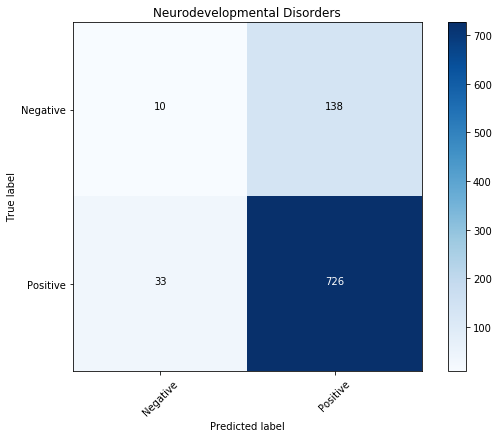

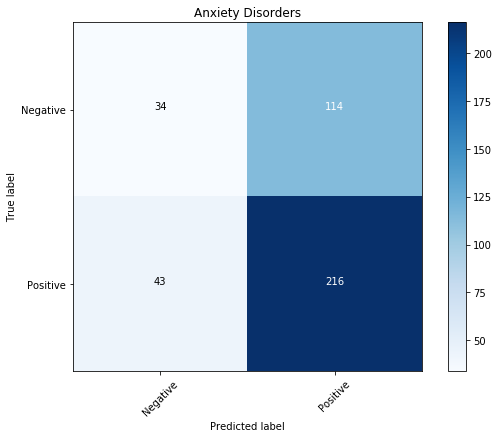

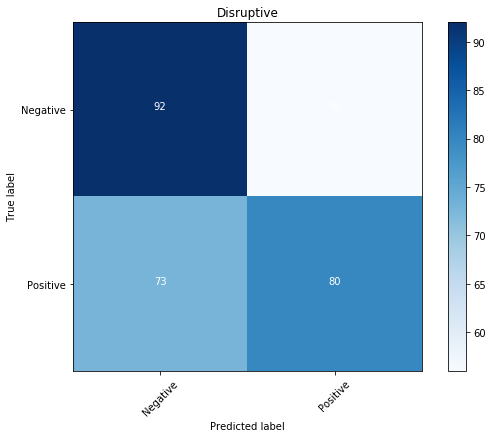

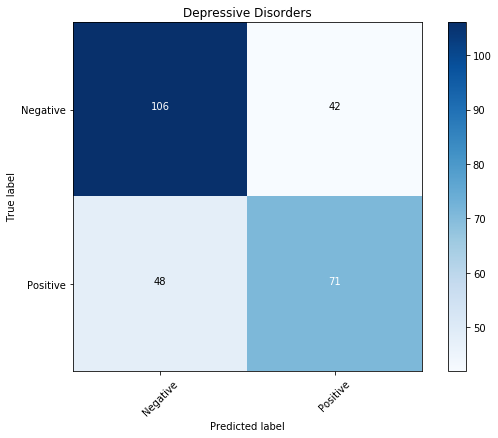

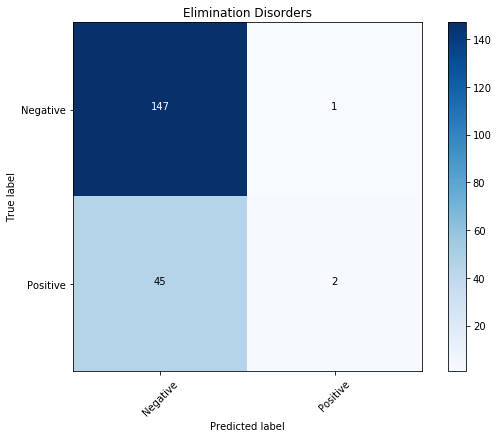

In [32]:
i = 0
for disorder in most_common_disorders: 
    if disorder == 'No Diagnosis Given': 
        continue

    plot_confusion_matrix(struct_mri_rf_conf[i], target_names=['Negative', 'Positive'], title=disorder)
    i += 1

#### SVM

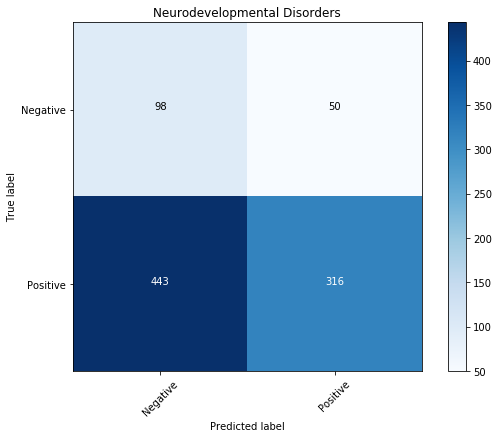

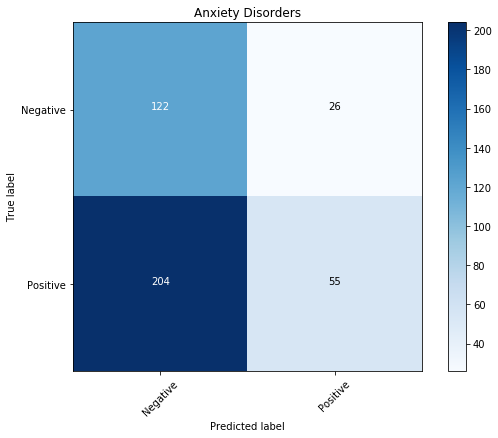

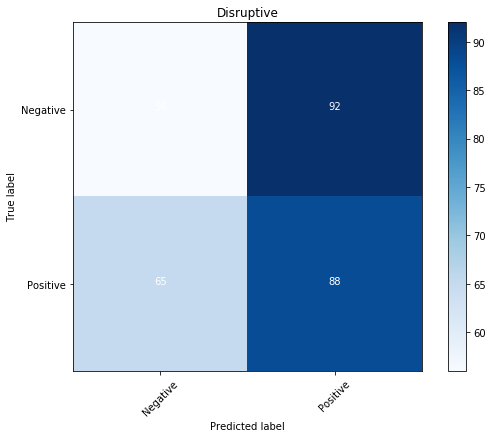

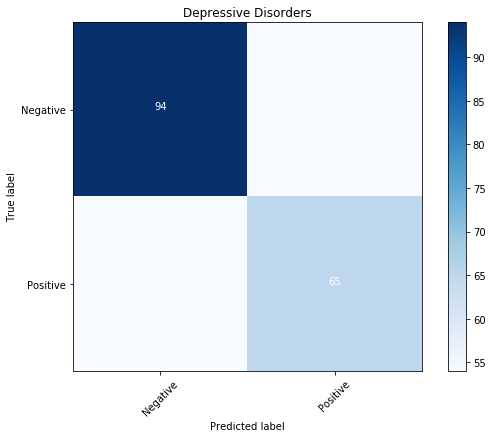

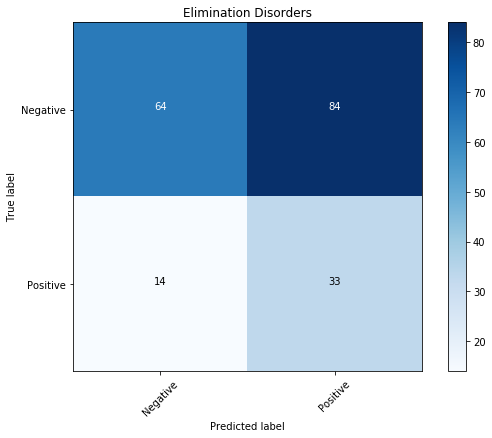

In [33]:
i = 0
for disorder in most_common_disorders: 
    if disorder == 'No Diagnosis Given': 
        continue

    plot_confusion_matrix(struct_mri_svm_conf[i], target_names=['Negative', 'Positive'], title=disorder)
    i += 1

In [34]:
for disorder in most_common_disorders: 
    if disorder == 'No Diagnosis Given': 
        continue

    rf_values = [v for v in struct_mri_rf_res[disorder].values()]
    svm_values = [v for v in struct_mri_svm_re[disorder].values()]
    x = np.arange(len(metrics))  # the label locations
    width = 0.4 # the width of the bars

    fig, ax = plt.subplots(figsize=(12,6))
    rects_rf = ax.bar(x + width/2, rf_values, width, label='RF')
    rects_svm = ax.bar(x - width/2, svm_values, width, label='SVM')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Score')
    ax.set_title(disorder)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.grid(True)
    ax.legend()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [36]:
struct_mri_rf_conf

array([[[ 10, 138],
        [ 33, 726]],

       [[ 34, 114],
        [ 43, 216]],

       [[ 92,  56],
        [ 73,  80]],

       [[106,  42],
        [ 48,  71]],

       [[147,   1],
        [ 45,   2]]])